In [1]:
import warnings

warnings.filterwarnings("ignore")

import os.path
import ssm
import pickle
import numpy as np
import pandas as pd
import scipy
import copy
from tqdm import tqdm

from runwise_ts_log_data import get_ts_log_data_blocked

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import to_rgba
import seaborn as sns

from sympy.utilities.iterables import multiset_permutations
from ssm.util import *
from scipy.stats import ttest_ind, wilcoxon, ranksums
from scipy.signal import find_peaks

from nilearn.image import load_img, new_img_like
from nilearn.plotting import plot_img_on_surf

from scipy.spatial.distance import cdist

In [2]:
with open('pkl/emoprox2_dataset_timeseries+inputs_MAX85.pkl','rb') as f:
    orig_df = pickle.load(f)
subj_list = sorted(orig_df['pid'].unique())
# subj_list = subj_list[:] # remove first 30 subjects
orig_df = orig_df[orig_df['pid'].isin(subj_list)]

In [3]:
K = 6
D = 10
N = 85
num_subjs = 92
M=20
num_resamples = 500

In [4]:
with open(f'pkl/all_dfs_models_K{K}_D{D}_N{N}_{num_subjs}subjs_{num_resamples}resamples.pkl','rb') as f:
    all_dfs,all_models = pickle.load(f)

In [5]:
with open(f'pkl/state_masks_K{K}_D{D}_N{N}_{num_subjs}subjs_{num_resamples}resamples.pkl','rb') as f:
    state_masks = pickle.load(f)

In [6]:
print(len(all_dfs),len(all_models),len(state_masks))

500 500 500


# ROI importances

In [7]:
for df,model,state_mask in tqdm(zip(all_dfs.values(),all_models.values(),state_masks.values())):
    As = model.dynamics.As
    bs = model.dynamics.bs
    C = model.emissions.Cs[0]
    d = model.emissions.ds[0]
    Cinv = np.linalg.pinv(C) 
    Ahat_columnnorm = np.zeros((K,N))
    for idx_state in range(K):
        # y_{t} = C x_{t} + d
        # x_{t+1} = A x_{t} + b
        # y_{t+1} = C x_{t+1} + d = C (A x_{t} + b) + d = C A Cinv y_{t} + C b + d
        Ahat_columnnorm[idx_state,:] = np.linalg.norm(C@As[idx_state]@Cinv,axis=0)

    df['roi_importance'] = [None]*df.shape[0]
    for idx_row,row in df.iterrows():
        y = row['timeseries']
        z = row['discrete_states']

        df.at[idx_row,'roi_importance'] = np.multiply(abs(y),Ahat_columnnorm[z,:])

500it [01:01,  8.18it/s]


In [8]:
hlag = 3
resps = []
zwin = []
zindwin = []
proxs = []
roiimps = []
trajs = []

for idx_resample in tqdm(range(1,1+num_resamples)):# [404]
    df = all_dfs[idx_resample]
    state_mask = state_masks[idx_resample]
    model = all_models[idx_resample]


    for idx_row, row in df.iterrows():
        prox = row['proximity']
        y = row['timeseries']
        z = row['discrete_states']
        x = row['continuous_states']
        roiimp = row['roi_importance']
        zind = np.stack([(z==idx_state) for idx_state in range(K)],axis=-1).astype('float')
        for t in find_peaks(prox)[0][1:-1]:
            if prox[t]>0.9: continue
            # if np.array2string(1+z[t-7+hlag:t+8+hlag]) not in significant_seqs: continue
            if t-7+hlag>=0 and t+8+hlag<=410:
                proxs.append(prox[t])
                resps.append(y[t-7+hlag:t+8+hlag,:])
                zindwin.append(zind[t-7+hlag:t+8+hlag,:])
                zwin.append(z[t-7+hlag:t+8+hlag])
                roiimps.append(roiimp[t-7+hlag:t+8+hlag,:])
                trajs.append(x[t-7+hlag:t+8+hlag,:])

zwin = np.stack(zwin)
proxs = np.array(proxs)



100%|██████████| 500/500 [01:06<00:00,  7.55it/s]


# Categorizing approach-retreat segments into quantiles based on proximity values

In [9]:
quintiles = np.percentile(proxs,100/10*np.arange(1,10))
labels = np.searchsorted(quintiles, proxs)

print(np.unique(labels))

# labels = np.zeros_like(proxs)
# print(labels.shape)
# labels[(proxs>0.72)&(proxs<0.8)] = 1
# labels[(proxs>0.8)] = 2

for idx_clust in range(labels.max()+1):
    print(np.sum(labels==idx_clust))

[0 1 2 3 4 5 6 7 8 9]
375807
375471
375831
375230
375692
375850
375450
375413
375823
375268


# Trajectories


In [10]:
all_attractors = {k:[] for k in range(K)}
all_dynamics = {k:[] for k in range(K)}
for idx_resample in tqdm(range(1,1+num_resamples)):
    model = all_models[idx_resample]
    state_mask = state_masks[idx_resample]

    for idx_state in range(K):
        if state_mask[idx_state]==1: continue
        A = model.dynamics.As[idx_state]
        b = model.dynamics.bs[idx_state]
        all_attractors[idx_state].append(np.linalg.inv(np.eye(D)-A) @ b)
        all_dynamics[idx_state].append(A)

avg_attractors = np.zeros((K,D))
for idx_state in range(K):
    avg_attractors[idx_state,:] = np.stack(all_attractors[idx_state]).mean(axis=0)

avg_dynamics = np.zeros((K,D,D))
for idx_state in range(K):
    avg_dynamics[idx_state,:,:] = np.stack(all_attractors[idx_state]).mean(axis=0)

100%|██████████| 500/500 [00:00<00:00, 15306.11it/s]


In [11]:

# avg_attractors = np.zeros((K,D))
# for idx_state in range(K):
#     # if state_mask[idx_state]==1: continue
#     A = model.dynamics.As[idx_state]
#     b = model.dynamics.bs[idx_state]
#     avg_attractors[idx_state,:] = np.linalg.inv(np.eye(D)-A) @ b

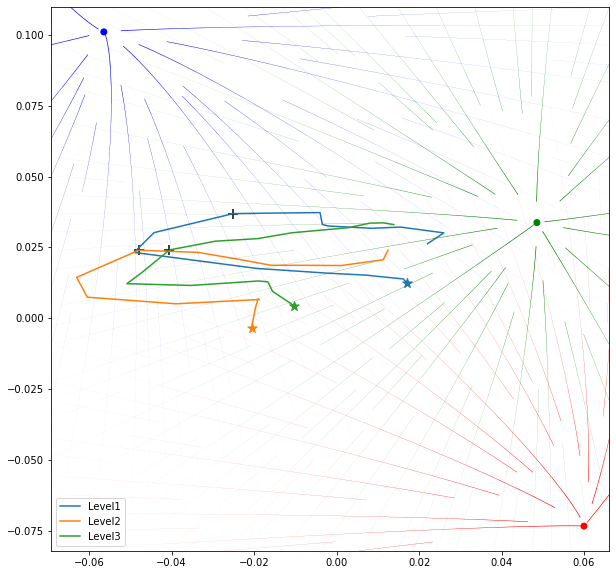

In [49]:
X = []
for idx_clust in range(4):#range(labels.max()+1):
    trajs_all = np.stack([trajs[i] for i,label in enumerate(labels) if label==idx_clust]) 
    trajs_all = np.mean(trajs_all,axis=0)
    X.append(trajs_all)

X = np.vstack(X)

# xs = np.vstack(list(df['continuous_states'].values))
cov = np.corrcoef(X.T)#avg_attractors[2:-1,:].T)
U,Lam,V = np.linalg.svd(cov)
pcs = U[:,:2] # using top 2 principal components

fig,ax = plt.subplots(1,1,figsize=(10,10))
attractors2d = avg_attractors @ pcs
ax.scatter(attractors2d[2:-1,0],attractors2d[2:-1,1],c=['g','b','r'])

for idx_clust in range(3):#labels.max()+1):
    trajs_all = np.stack([trajs[i] for i,label in enumerate(labels) if label==idx_clust])
    mean_trajs = np.mean(trajs_all,axis=0) @ pcs
    ax.scatter(mean_trajs[0,0],mean_trajs[0,1],marker='*',s=100)
    ax.plot(mean_trajs[:,0],mean_trajs[:,1],label=f'Level{idx_clust+1}')
    ax.scatter(mean_trajs[7,0],mean_trajs[7,1],marker='+',c='k',s=100)

colors = 'wwgbrw'
for idx_state in [2,3,4]:
    A = avg_dynamics[idx_state,:,:]
    A2d = np.linalg.pinv(pcs) @ A @ pcs
    # fig,ax = plt.subplots(1,1,figsize=(5,5))
    xmin,xmax = ax.get_xlim()
    ymin,ymax = ax.get_ylim()
    xtup = (xmin,xmax,10)
    ytup = (ymin,ymax,10)
    x_range = np.linspace(*xtup)
    y_range = np.linspace(*ytup)
    x_coords, y_coords = np.meshgrid(x_range,y_range)
    u,v = np.zeros_like(x_coords),np.zeros_like(y_coords)
    
    for i in range(x_coords.shape[0]):
        for j in range(x_coords.shape[1]):
            vec = np.array([x_coords[i,j],y_coords[i,j]])-attractors2d[idx_state,:]
            # print(vec.shape, A2d.shape)
            # print((A2d@vec).shape)

            dv = A2d@vec - vec
            u[i,j],v[i,j] = dv[0],dv[1]

    # points = np.stack([x_coords,y_coords])
    # dpoints = A2d @ points - points
    # u, v = dpoints[0,:], dpoints[1,:]
    ax.streamplot(x_coords,y_coords,u,v,color=colors[idx_state],linewidth=np.exp(-30*np.sqrt(u*u+v*v)),arrowsize=0)
# TODO: add field lines around attractors, tryout streamplot()

ax.legend(loc='lower left')


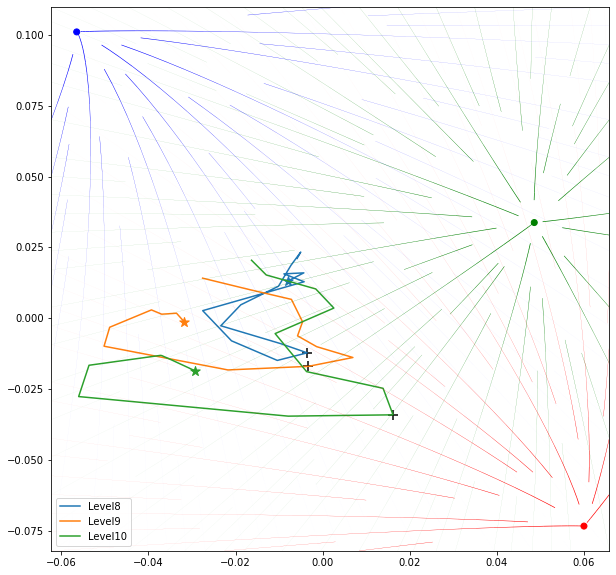

In [50]:
X = []
for idx_clust in range(4):#range(6,labels.max()+1):#range(labels.max()+1):
    trajs_all = np.stack([trajs[i] for i,label in enumerate(labels) if label==idx_clust]) 
    trajs_all = np.mean(trajs_all,axis=0)
    X.append(trajs_all)

X = np.vstack(X)

# xs = np.vstack(list(df['continuous_states'].values))
cov = np.corrcoef(X.T)#avg_attractors[2:-1,:].T)
U,Lam,V = np.linalg.svd(cov)
pcs = U[:,:2] # using top 2 principal components

fig,ax = plt.subplots(1,1,figsize=(10,10))
attractors2d = avg_attractors @ pcs
ax.scatter(attractors2d[2:-1,0],attractors2d[2:-1,1],c=['g','b','r'])

for idx_clust in range(7,labels.max()+1):
    trajs_all = np.stack([trajs[i] for i,label in enumerate(labels) if label==idx_clust])
    mean_trajs = np.mean(trajs_all,axis=0) @ pcs
    ax.scatter(mean_trajs[0,0],mean_trajs[0,1],marker='*',s=100)
    ax.plot(mean_trajs[:,0],mean_trajs[:,1],label=f'Level{idx_clust+1}')
    ax.scatter(mean_trajs[7,0],mean_trajs[7,1],marker='+',c='k',s=100)

colors = 'wwgbrw'
for idx_state in [2,3,4]:
    A = avg_dynamics[idx_state,:,:]
    A2d = np.linalg.pinv(pcs) @ A @ pcs
    # fig,ax = plt.subplots(1,1,figsize=(5,5))
    xmin,xmax = ax.get_xlim()
    ymin,ymax = ax.get_ylim()
    xtup = (xmin,xmax,10)
    ytup = (ymin,ymax,10)
    x_range = np.linspace(*xtup)
    y_range = np.linspace(*ytup)
    x_coords, y_coords = np.meshgrid(x_range,y_range)
    u,v = np.zeros_like(x_coords),np.zeros_like(y_coords)
    
    for i in range(x_coords.shape[0]):
        for j in range(x_coords.shape[1]):
            vec = np.array([x_coords[i,j],y_coords[i,j]])-attractors2d[idx_state,:]
            # print(vec.shape, A2d.shape)
            # print((A2d@vec).shape)

            dv = A2d@vec - vec
            u[i,j],v[i,j] = dv[0],dv[1]

    # points = np.stack([x_coords,y_coords])
    # dpoints = A2d @ points - points
    # u, v = dpoints[0,:], dpoints[1,:]
    ax.streamplot(x_coords,y_coords,u,v,color=colors[idx_state],linewidth=np.exp(-30*np.sqrt(u*u+v*v)),arrowsize=0)
# TODO: add field lines around attractors, tryout streamplot()

ax.legend(loc='lower left')


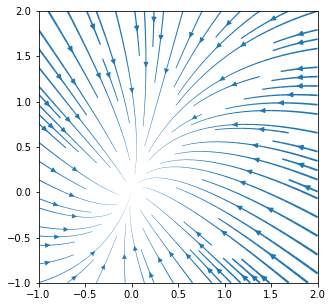

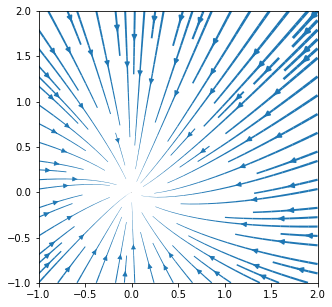

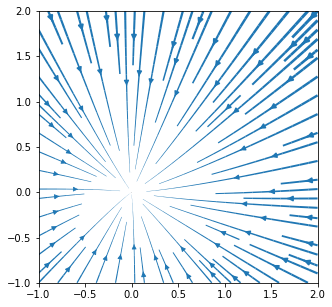

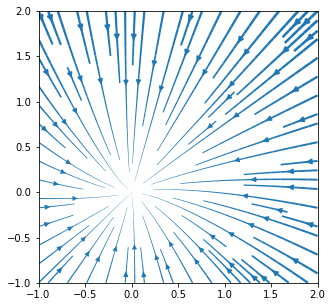

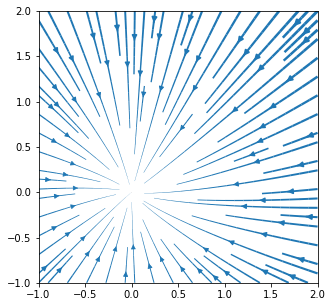

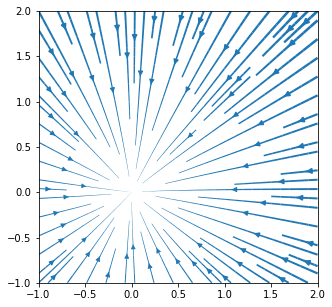

In [22]:
for idx_state in range(K):
    A = avg_dynamics[idx_state,:,:]
    A2d = np.linalg.pinv(pcs) @ A @ pcs
    fig,ax = plt.subplots(1,1,figsize=(5,5))
    xmin,xmax = ax.get_xlim()
    ymin,ymax = ax.get_ylim()
    xtup = (xmin-1,xmax+1,10)
    ytup = (ymin-1,ymax+1,10)
    x_range = np.linspace(*xtup)
    y_range = np.linspace(*ytup)
    x_coords, y_coords = np.meshgrid(x_range,y_range)
    u,v = np.zeros_like(x_coords),np.zeros_like(y_coords)
    
    for i in range(x_coords.shape[0]):
        for j in range(x_coords.shape[1]):
            vec = np.array([x_coords[i,j],y_coords[i,j]])
            # print(vec.shape, A2d.shape)
            # print((A2d@vec).shape)

            dv = A2d@vec - vec
            u[i,j],v[i,j] = dv[0],dv[1]

    # points = np.stack([x_coords,y_coords])
    # dpoints = A2d @ points - points
    # u, v = dpoints[0,:], dpoints[1,:]
    ax.streamplot(x_coords,y_coords,u,v,linewidth=np.sqrt(u*u+v*v))

(15, 10) (3, 10)


(15, 10) (3, 10)
(15, 10) (3, 10)
(15, 10) (3, 10)
(15, 10) (3, 10)
(15, 10) (3, 10)
(15, 10) (3, 10)
(15, 10) (3, 10)
(15, 10) (3, 10)
(15, 10) (3, 10)


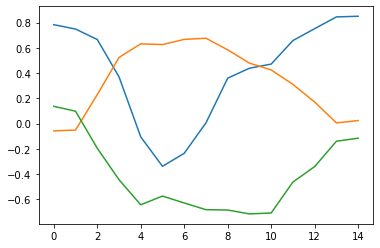

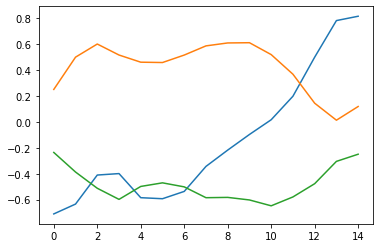

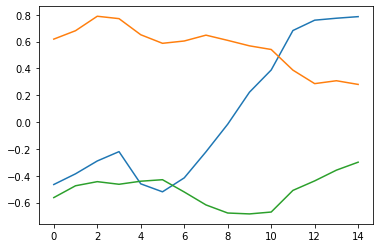

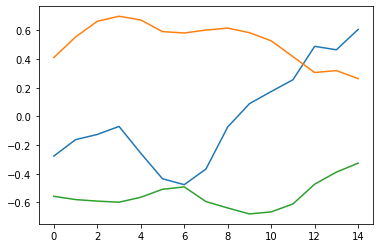

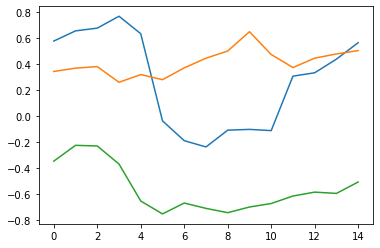

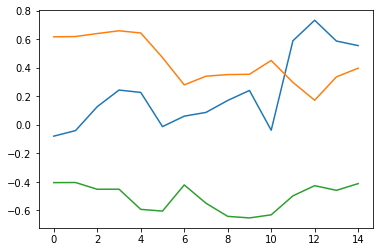

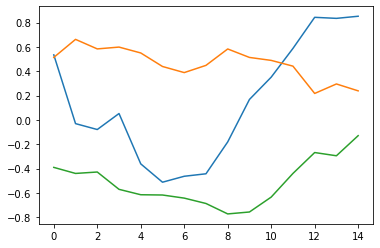

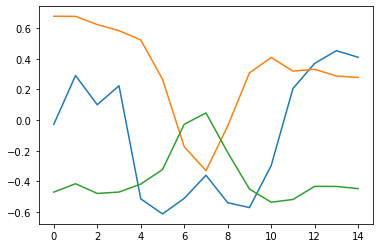

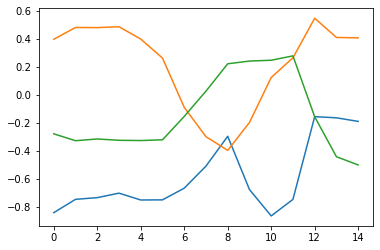

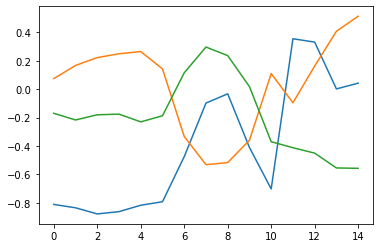

In [37]:
for idx_clust in range(labels.max()+1):
    trajs_all = np.stack([trajs[i] for i,label in enumerate(labels) if label==idx_clust]) 
    trajs_all = np.mean(trajs_all,axis=0)
    print(trajs_all.shape, avg_attractors[2:-1,:].shape)
    trajs_sim = np.corrcoef(trajs_all,avg_attractors[2:-1,:])
    trajs_sim = trajs_sim[:15,:]
    trajs_sim = trajs_sim[:,15:]
    fig = plt.figure()
    plt.plot(trajs_sim)

(15, 6)
(15, 6)
(15, 6)
(15, 6)
(15, 6)
(15, 6)
(15, 6)
(15, 6)
(15, 6)
(15, 6)


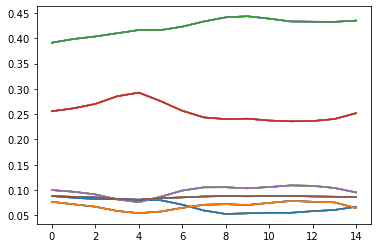

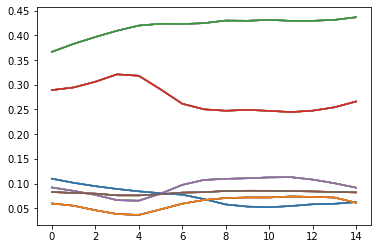

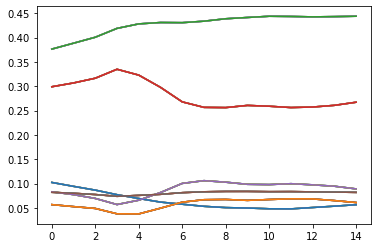

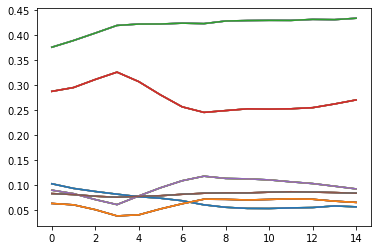

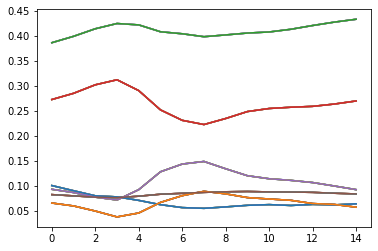

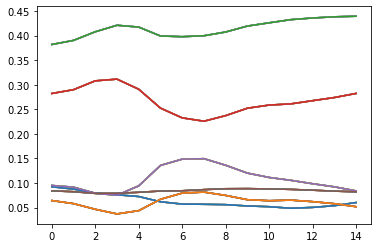

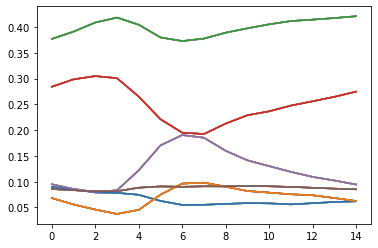

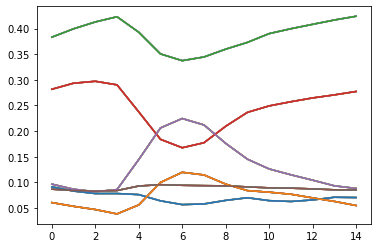

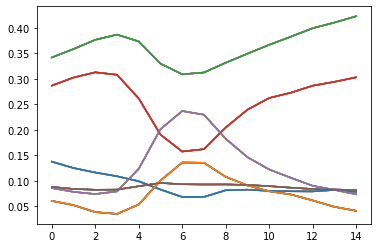

Error in callback <function flush_figures at 0x7efdd65743a0> (for post_execute):


KeyboardInterrupt: 

In [38]:
for idx_clust in range(labels.max()+1):
    zinds = np.stack([zindwin[i] for i,label in enumerate(labels) if label==idx_clust])
    mean_state_probabilities = np.mean(zinds,axis=0)
    print(mean_state_probabilities.shape)
    plt.figure()
    for idx_state in range(K):
        plt.plot(mean_state_probabilities)

In [10]:
def vec2img(vec:np.ndarray):
    atlasimg = load_img('/home/joyneelm/templates/MAX_ROIs_final_gm_85.nii.gz')
    atlasdata = atlasimg.get_fdata()
    nrois = vec.shape[0]
    retdata = np.zeros_like(atlasdata)
    for idx_roi in range(nrois):
        retdata[atlasdata==(idx_roi+1)] = vec[idx_roi]
    ret = new_img_like(ref_niimg=atlasimg,data=retdata)
    return ret

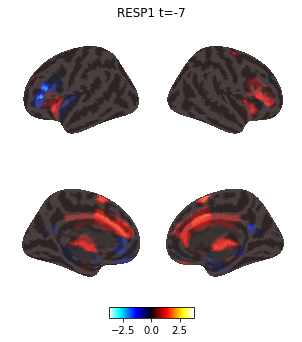

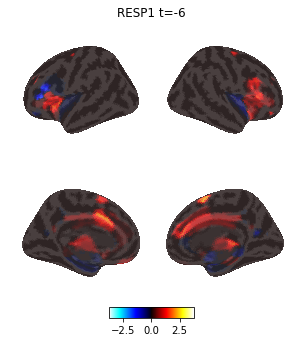

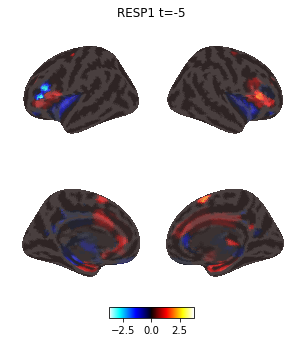

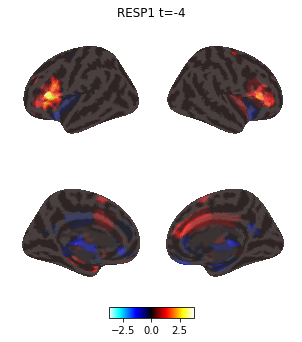

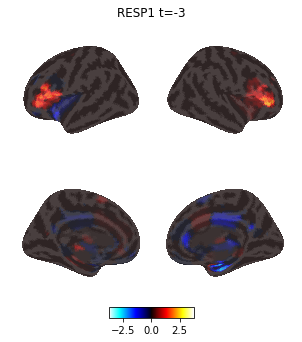

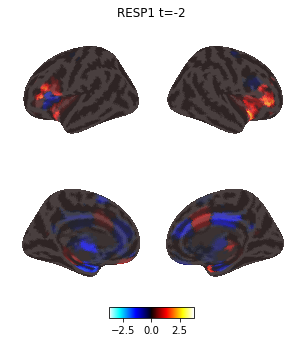

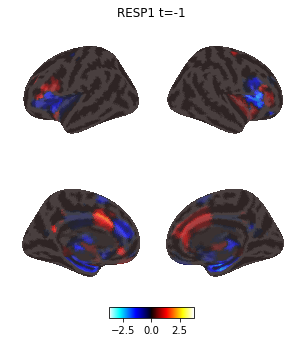

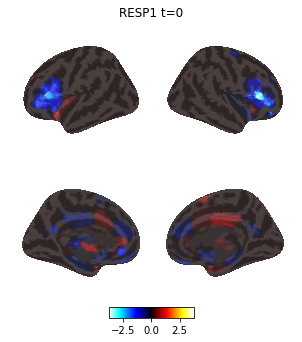

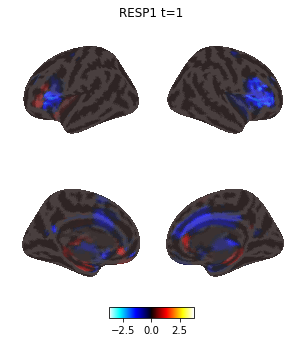

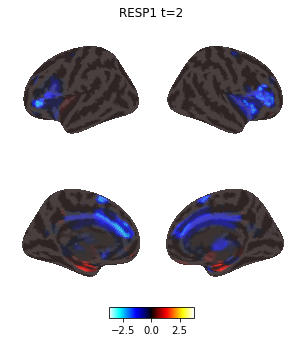

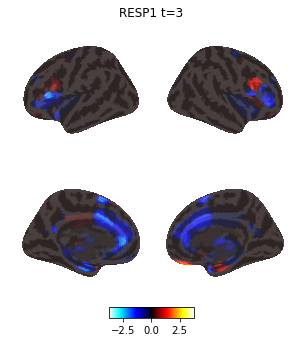

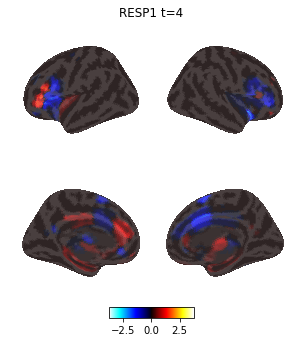

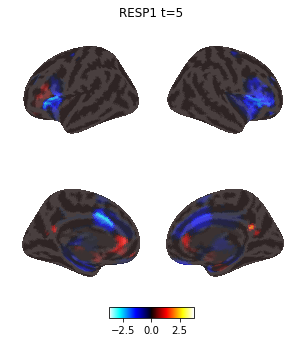

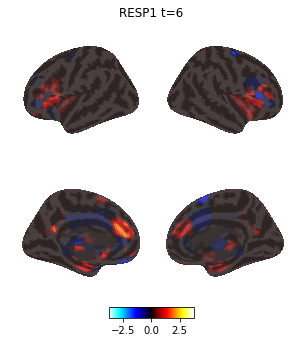

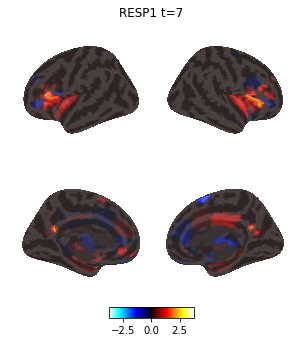

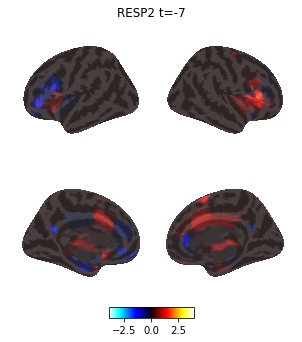

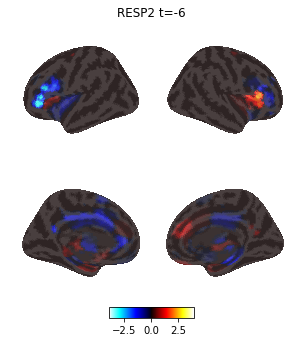

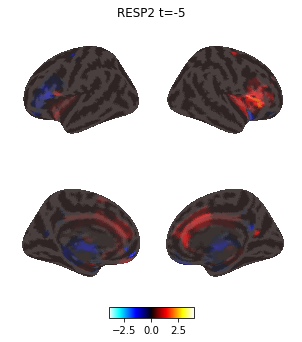

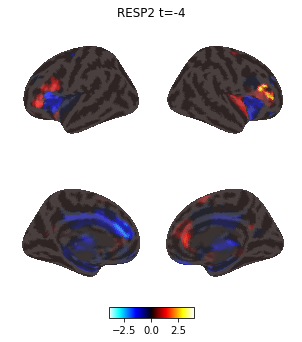

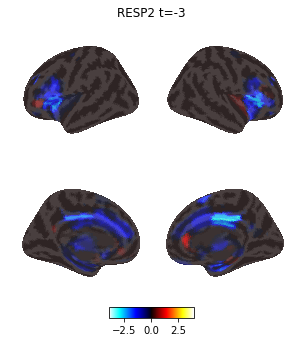

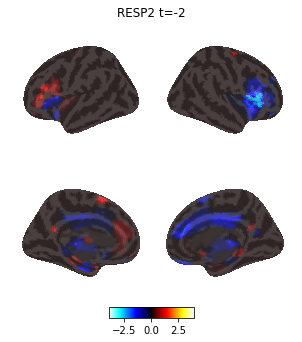

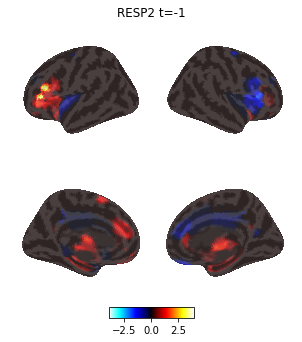

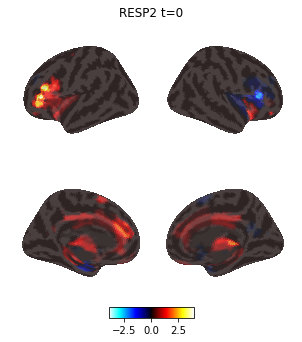

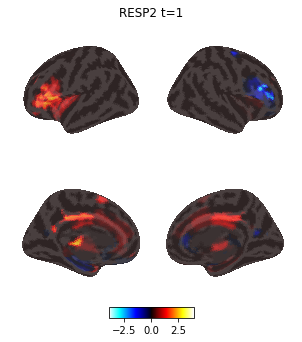

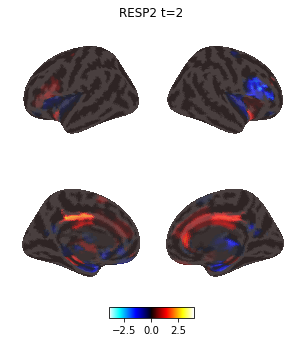

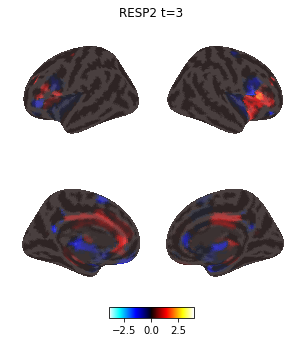

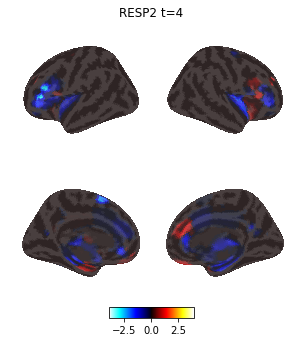

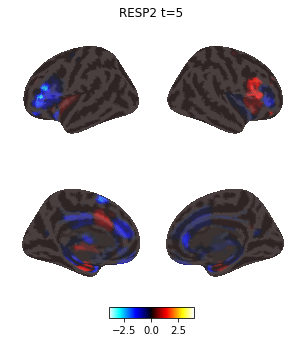

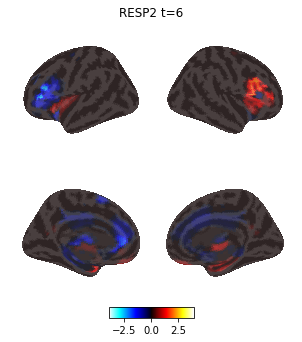

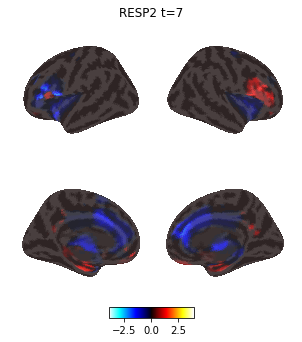

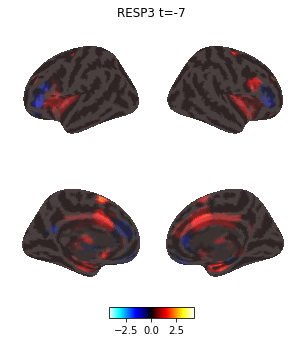

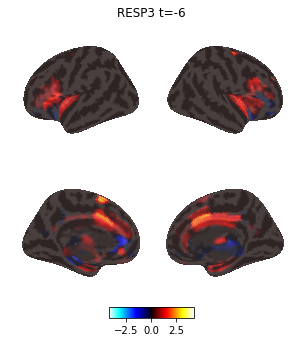

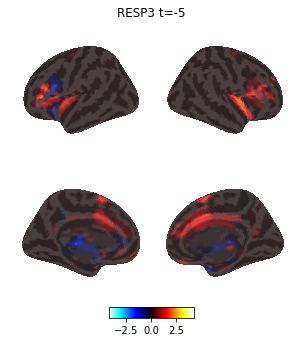

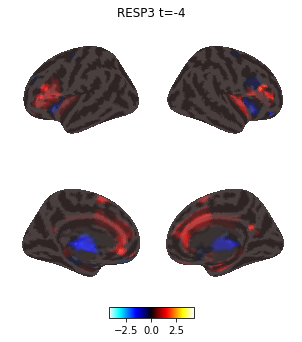

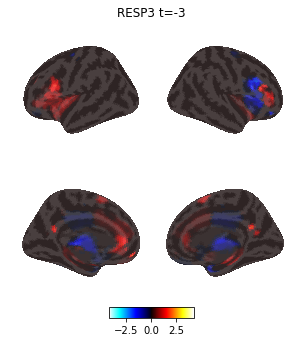

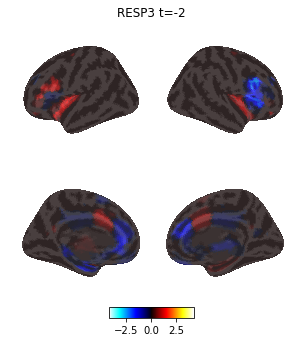

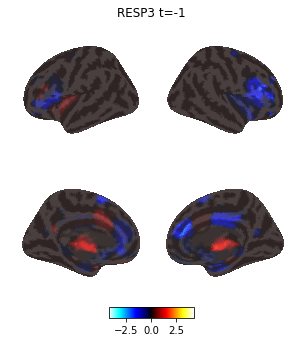

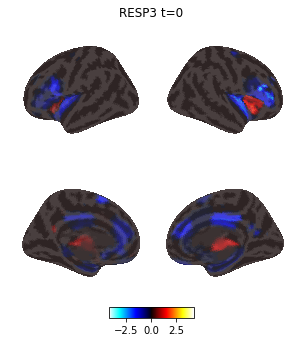

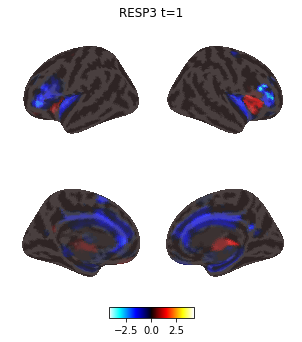

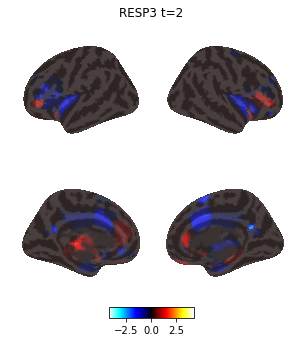

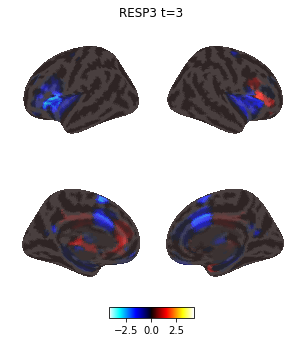

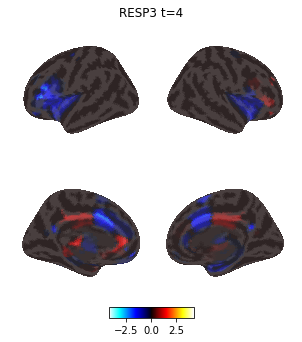

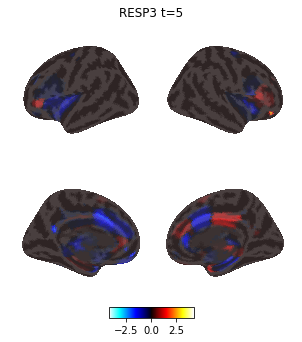

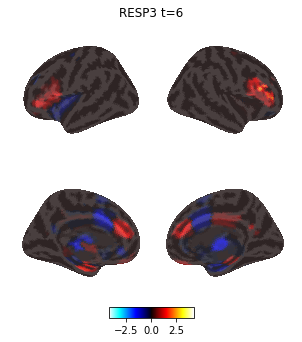

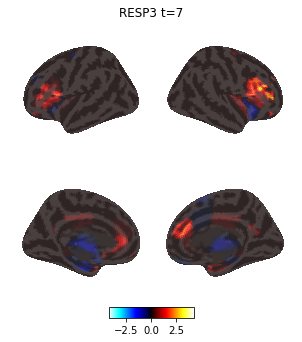

In [11]:
for idx_clust in range(3):
    roi_imps_all = np.stack([roiimps[i] for i,label in enumerate(labels) if label==idx_clust])
    mean_imps = np.mean(roi_imps_all,axis=0)
    mean_imps -= np.expand_dims(np.mean(mean_imps,axis=0),axis=0)
    mean_imps /= np.expand_dims(np.std(mean_imps,axis=1),axis=1)
    vmin = np.min(mean_imps)
    for t in range(mean_imps.shape[0]):
        img = vec2img(mean_imps[t,:])
        # plot_stat_map(img)

        fig,ax = plot_img_on_surf(
            stat_map=img,
            views=["lateral", "medial"],
            hemispheres=["left", "right"],
            colorbar=True,
            inflate=True,
            title=f'RESP{idx_clust+1} t={t-7}',     
            vmax=np.max(mean_imps),
            # cmap='viridis',
            bg_on_data=True,
        )
        # ax.set_title(f'RESP{idx_clust+1} t={t-7}',fontsize=14)
        # fig.savefig(f'./roi_importance/RESP{idx_clust+1}_t={t:02d}.png',dpi=300,bbox_inches='tight',facecolor='white', transparent=False)
    


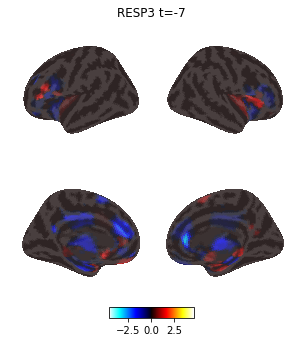

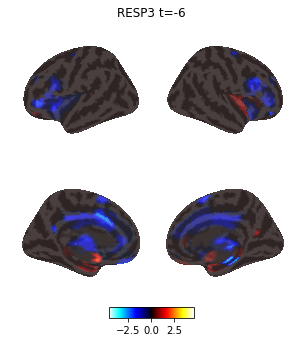

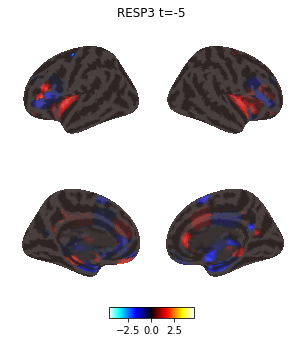

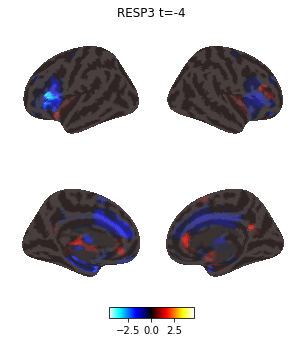

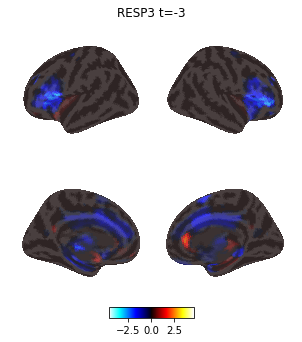

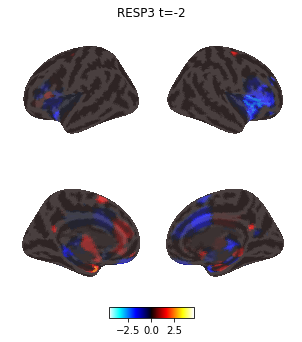

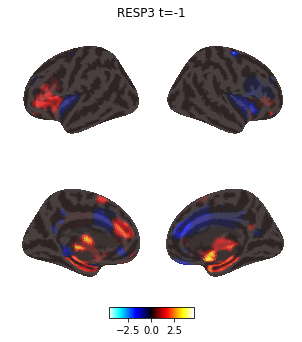

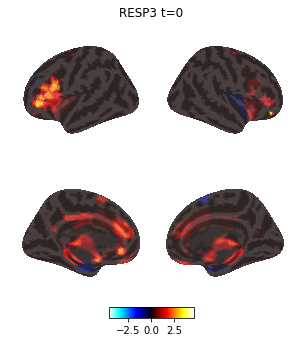

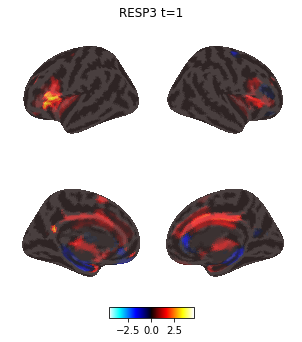

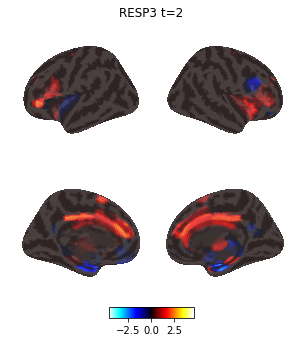

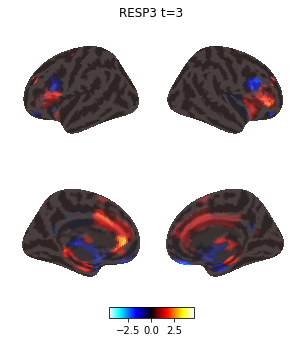

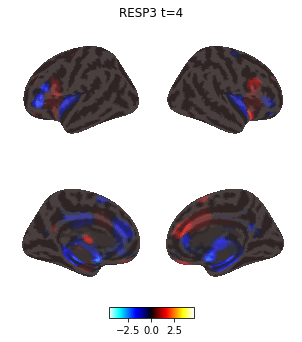

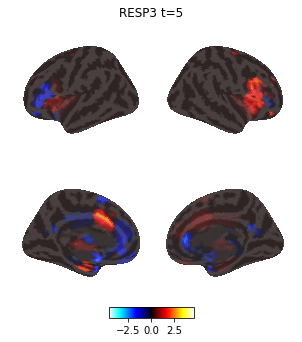

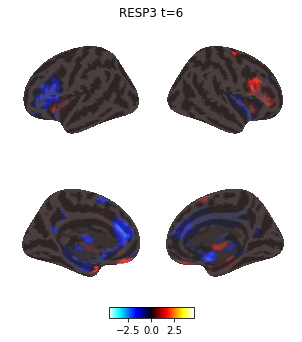

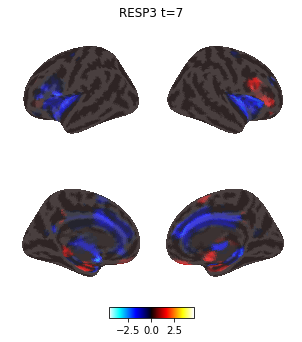

In [15]:
# for idx_clust in range(3):
roi_imps_all1 = np.stack([roiimps[i] for i,label in enumerate(labels) if label==0])
roi_imps_all2 = np.stack([roiimps[i] for i,label in enumerate(labels) if label==1])
roi_imps_all3 = np.stack([roiimps[i] for i,label in enumerate(labels) if label==2])

def normalize(X):
    X -= np.expand_dims(np.mean(X,axis=0),axis=0)
    X /= np.expand_dims(np.std(X,axis=0),axis=0)
    return X

mean_imps1 = normalize(np.mean(roi_imps_all1,axis=0))
mean_imps2 = normalize(np.mean(roi_imps_all2,axis=0))
mean_imps3 = normalize(np.mean(roi_imps_all3,axis=0))

diff_imps = mean_imps2-mean_imps1
vlim = np.max(np.abs(diff_imps))

for t in range(mean_imps.shape[0]):
    img = vec2img(diff_imps[t,:])
    # plot_stat_map(img)

    fig,ax = plot_img_on_surf(
        stat_map=img,
        views=["lateral", "medial"],
        hemispheres=["left", "right"],
        colorbar=True,
        inflate=True,
        title=f'RESP{idx_clust+1} t={t-7}',     
        vmax=vlim,
        # cmap='viridis',
        bg_on_data=True,
    )
        # ax.set_title(f'RESP{idx_clust+1} t={t-7}',fontsize=14)
        # fig.savefig(f'./roi_importance/RESP{idx_clust+1}_t={t:02d}.png',dpi=300,bbox_inches='tight',facecolor='white', transparent=False)
    
